# Experiment 1: Dependent test samples inflate confidence

This notebook reproduces **Experiment 1** from our paper on validation pitfalls in surgical AI.  
It demonstrates how **ignoring hierarchical dependencies** in temporally structured surgical video data can lead to **severely underestimated uncertainty**, i.e., overly narrow confidence intervals (CIs).

## Core idea

Surgical video data is inherently **hierarchical**: multiple frames originate from the same patient case (video) and are correlated. We compare two resampling strategies for estimating **95% bootstrap CIs** of common performance metrics:

1. **Naive bootstrap**: Resamples individual frames from the full test set, implicitly assuming independence.

2. **Hierarchical bootstrap**: Resamples **videos/patients first**, then resamples frames **within** each sampled video, explicitly accounting for dependencies.

All model outputs (predictions) are treated as **fixed**. Only the **CI estimation procedure** differs.

## Tasks and datasets

We cover two representative benchmark tasks:

- **Binary instrument segmentation (RobustMIS 2019)**  
  - Algorithms: 10 challenge submissions  
  - Metrics: Dice Similarity Coefficient (DSC), Normalized Surface Dice (NSD)  
  - Hierarchy: patient/video level (n = 10)

- **Surgical action triplet recognition (CholecT45)**  
  - Model: Swin-Base Transformer (precomputed predictions)  
  - Metrics: mean Average Precision (mAP), class-weighted mAP, top-5 Accuracy  
  - Hierarchy: patient/video level (n = 45)  
  - Cross-validation folds are handled separately.
  
## Software dependencies

This notebook uses standard Python libraries for data handling, statistical resampling, metric computation, and visualization. All required imports are listed explicitly below.

## How to run

Run the notebook **top-to-bottom** (Kernel --> Restart & Run All). 

If paths need adjustment, do so in the dedicated "data loading" section only.

In [1]:
# =========================
# core libraries
# =========================
import numpy as np
import pandas as pd

# =========================
# statistics and resampling
# =========================
from scipy import stats
from scipy.stats import norm
from sklearn.utils import resample

# =========================
# plotting
# =========================
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# deep learning / metrics
# =========================
import torch 
from torchmetrics import AveragePrecision as AP
from torcheval.metrics import TopKMultilabelAccuracy

# =========================
# utilities
# =========================
import concurrent.futures
import itertools
from scipy.stats import norm

In [ ]:
# =========================
# reproducibility settings
# =========================
import random

RANDOM_SEED = 42
N_BOOTSTRAPS = 1000

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Data loading  and data structure
This section loads the precomputed prediction results used for the two tasks considered in Experiment 1. Only tabular result files are required; no raw images or videos are accessed.

### RobustMIS (binary instrument segmentation)
The RobustMIS results are provided as a tabular file containing frame-level performance values for all challenge submissions.

Relevant columns for this experiment:
- `frame`: unique frame identifier
- `surgery_number`: patient / video identifier (hierarchy level)
- `team_name`: algorithm identifier; pseudonymized as A1-A10
- `DSC`, `NSD`: frame-level segmentation metrics

For this experiment, we restrict the analysis to **Stage 3**, which corresponds to the final held-out test set used in the original challenge.

In [3]:
# Load RobustMIS frame-level results
robustmis_data= pd.read_csv('robustmis_results_binary_segmentation_anonym.csv')

print(robustmis_data[['surgery_number', 'frame']].nunique())

robustmis_data

surgery_number      10
frame             2231
dtype: int64


,Unnamed: 0,surgery_type,surgery_number,frame_nr,phase,frame,stage,task,team_name,DSC,NSD,surgery
0,10091,Sigma,1,1500,0,1500_Sigma_1,Stage_3,Testcase.BINARY_SEGMENTATION,A1,0.936055,0.947957,Sigma_1
1,10092,Sigma,1,1500,0,1500_Sigma_1,Stage_3,Testcase.BINARY_SEGMENTATION,A9,0.000000,0.000000,Sigma_1
2,10093,Sigma,1,1500,0,1500_Sigma_1,Stage_3,Testcase.BINARY_SEGMENTATION,A8,0.921258,0.954009,Sigma_1
3,10094,Sigma,1,1500,0,1500_Sigma_1,Stage_3,Testcase.BINARY_SEGMENTATION,A2,0.972946,0.984471,Sigma_1
4,10095,Sigma,1,1500,0,1500_Sigma_1,Stage_3,Testcase.BINARY_SEGMENTATION,A10,0.939981,0.953592,Sigma_1
...,...,...,...,...,...,...,...,...,...,...,...,...
22305,32396,Sigma,10,232912,12,232912_Sigma_10,Stage_3,Testcase.BINARY_SEGMENTATION,A7,0.596940,0.645750,Sigma_10
22306,32397,Sigma,10,232912,12,232912_Sigma_10,Stage_3,Testcase.BINARY_SEGMENTATION,A3,0.926841,0.989964,Sigma_10
22307,32398,Sigma,10,232912,12,232912_Sigma_10,Stage_3,Testcase.BINARY_SEGMENTATION,A6,0.643824,0.693771,Sigma_10
22308,32399,Sigma,10,232912,12,232912_Sigma_10,Stage_3,Testcase.BINARY_SEGMENTATION,A4,0.904129,0.980065,Sigma_10


### CholecT45 (surgical action triplet recognition)

The CholecT45 results are loaded from a tabular file containing frame-level predictions and reference labels for all cross-validation folds.

Relevant columns for this experiment:
- `video`: patient / video identifier (hierarchy level)
- `frame`: frame index within each video
- `fold`: cross-validation fold identifier
- `tri*`: reference triplet labels
- numeric columns: model prediction scores per triplet class

Metrics are computed per fold and aggregated at the video level before confidence interval estimation.

In [4]:
# Load CholecT45 frame-level predictions and labels
atr_data=pd.read_csv('cholectriplet_official_CV_split.csv')

print(atr_data[['video', 'fold', 'frame']].nunique())
atr_data

video      45
fold        5
frame    3946
dtype: int64


,Unnamed: 0.1,Unnamed: 0,folder,frame,video,image_path,image_id,tri0,tri1,tri2,...,121,122,123,124,125,126,127,128,129,130
0,0,1734,VID02,0,VID02,VID02/000000.png,1_0,0,0,0,...,-8.449802,-4.556970,-6.046053,-4.730402,-10.427304,-6.008317,-9.719086,-8.599679,-4.695409,-4.421620
1,1,1735,VID02,1,VID02,VID02/000001.png,1_1,0,0,0,...,-9.517592,-5.897165,-6.788304,-5.946767,-10.029009,-5.827394,-10.087034,-8.868259,-4.774901,-4.759214
2,2,1736,VID02,2,VID02,VID02/000002.png,1_2,0,0,0,...,-8.359022,-6.035301,-7.059429,-4.825499,-11.048567,-6.471086,-10.463810,-9.779274,-2.844463,-4.219637
3,3,1737,VID02,3,VID02,VID02/000003.png,1_3,0,0,0,...,-7.687274,-4.507718,-6.158801,-4.501435,-10.222450,-5.801592,-9.727282,-8.993421,-2.294889,-3.809969
4,4,1738,VID02,4,VID02,VID02/000004.png,1_4,0,0,0,...,-7.932438,-5.102842,-6.545661,-3.986576,-10.736591,-6.453399,-9.891449,-9.280207,-3.863312,-3.809823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90484,14949,85344,VID78,735,VID78,VID78/000735.png,42_735,0,0,0,...,-7.132306,-6.696518,-5.140392,-2.421838,-7.500995,-5.350337,-9.888584,-7.691432,1.120965,-1.339579
90485,14950,85345,VID78,736,VID78,VID78/000736.png,42_736,0,0,0,...,-8.203977,-6.820611,-2.701924,-4.734481,-6.012855,-5.153308,-9.147311,-6.980660,0.356576,-0.886650
90486,14951,85346,VID78,737,VID78,VID78/000737.png,42_737,0,0,0,...,-8.283792,-7.162216,-3.212644,-5.715859,-7.095611,-7.061913,-10.233379,-9.329947,3.077393,-1.971059
90487,14952,85347,VID78,738,VID78,VID78/000738.png,42_738,0,0,0,...,-9.624950,-7.548312,-6.016334,-5.792638,-7.715746,-7.784707,-11.141857,-9.100578,3.724828,-1.295250


## Bootstrap strategies and hierarchy handling

This section defines the two bootstrap strategies used to estimate confidence intervals for all metrics.

### Naive bootstrap

The naive bootstrap resamples **individual frames** from the full test set with replacement, implicitly assuming independence between all frames. For each bootstrap sample, the metric is computed on the resampled data and aggregated across frames.

### Hierarchical bootstrap

The hierarchical bootstrap explicitly accounts for the data hierarchy:
1. **Videos / patients** are resampled with replacement.
2. **Frames** are resampled with replacement *within* each selected video.
3. The metric is computed per bootstrap sample and averaged across videos.

This procedure captures additional variance introduced at the patient/video level that is ignored by the naive bootstrap.

### Hierarchical mean

In addition to confidence interval estimation, we compute a **hierarchically aggregated mean** by first averaging metric values **within each video/patient** and then averaging across videos. 

In [5]:
def bootstrap_hierarchical_one_level(data, n_iterations, level_1, metric):
    """
    Hierarchical bootstrap with one explicit hierarchy level (e.g., video/patient).

    Parameters
    ----------
    data : pd.DataFrame
        Input data containing frame-level observations.
    n_iterations : int
        Number of bootstrap iterations.
    level_1 : str
        Column name defining the higher-level unit (e.g., video or patient).
    metric : str or callable
        Metric to compute. If str, must be a column name (e.g., 'DSC', 'NSD').
        If callable, the function is applied to the resampled data.
        
    Returns
    -------
    bootstrap_samples : list of float
        List of bootstrap estimates of the mean metric value, one entry per bootstrap iteration.
    """
    
    bootstrap_samples = []
    
    level_1_units  = data[level_1].unique()
    
    for _ in range(n_iterations):
        bootstrap_data = []
        
        # Resample higher-level units (videos / patients)
        sampled_units = resample(level_1_units)

        for unit in sampled_units:

            unit_data = data[data[level_1] == unit]
            
            # Resample frames within each selected unit
            sampled_frames = resample(unit_data)
            
            if not metric in ['DSC', 'NSD']:
                bootstrap_data.append(metric(sampled_frames))
            else:
                bootstrap_data.extend(sampled_frames[metric])

        # Average metric across sampled video/surgery number
        bootstrap_samples.append(np.mean(bootstrap_data))
    
    return bootstrap_samples


In [6]:
def bootstrap_naive(data, n_iterations, metric):
    """
    Naive (frame-level) bootstrap confidence interval.
    
    Parameters
    ----------
    data : pd.DataFrame
        Input data containing frame-level observations.
    n_iterations : int
        Number of bootstrap iterations.
    level_1 : str
        Column name defining the higher-level unit (e.g., video or patient).
    metric : str or callable
        Metric to compute. If str, must be a column name (e.g., 'DSC', 'NSD').
        If callable, the function is applied to the resampled data.
        
    Returns
    -------
    ci_lower : float
        Lower bound of the percentile-based confidence interval.
    ci_upper : float
        Upper bound of the percentile-based confidence interval.
    """
    
    scores = []

    # Perform bootstrap sampling
    for _ in range(n_iterations):
        
        # Resample with replacement
        resample_df = resample(data)

        if not metric in ['DSC', 'NSD']:
            m = metric(resample_df)
            
            # Convert torch tensor to float if needed
            if hasattr(m, "item"):
                m = m.item()
            
            scores.append(m)
        else:
            scores.append(np.mean(resample_df[metric]))

    ci_lower = np.percentile(scores, 2.5)  # 2.5th percentile
    ci_upper = np.percentile(scores, 97.5)  # 97.5th percentile

    return ci_lower, ci_upper

In [7]:
def hierarchical_mean(data, level_1, metric):
    """
    Computes the mean metric value by first aggregating at the higher hierarchy level (e.g., per video) and 
    then averaging across units.
    
    Parameters
    ----------
    data : pd.DataFrame
        Input data containing frame-level observations.
    n_iterations : int
        Number of bootstrap iterations.
    level_1 : str
        Column name defining the higher-level unit (e.g., video or patient).
    metric : str or callable
        Metric to compute. If str, must be a column name (e.g., 'DSC', 'NSD').
        If callable, the function is applied to the resampled data.
        
    Returns
    -------
    mean_value : float
        Hierarchically aggregated mean metric value.
    """
    
    level_1_units = data[level_1].unique()
    per_unit_means = []
    
    for unit in level_1_units:
        unit_data = data[data[level_1] == unit]
        if not metric in ['DSC', 'NSD']:
            mean=metric(unit_data)
            per_unit_means.append(mean)
        else:
            per_unit_means.append(np.mean(unit_data[metric]))

    return np.mean(per_unit_means)

## Define metrics for Action Triplet Recognition

This section defines the metrics used for the surgical action triplet recognition task (CholecT45).

All metrics are computed in a **multilabel classification setting** using precomputed frame-level prediction scores and reference labels. The implementations mirror the validation protocol used in the original benchmark, with minor extensions for class imbalance handling.

Predictions are treated as fixed and no model training is performed in this notebook.

In [8]:
class CFG:
    device =  "cpu"
    metric_tsize = 100  
    col0 = "tri0" 

In [9]:
def compute_mAP_naive(data, CFG=CFG):
    """
    Computes the mean Average Precision (mAP) for surgical action triplet recognition.

    The metric is computed using micro-averaging across all triplet classes, following the evaluation protocol of the 
    original benchmark.

    Parameters
    ----------
    data : pd.DataFrame
        Input data containing frame-level predictions and reference labels. The DataFrame is expected to include:
        - Reference columns starting at `CFG.col0`
        - Prediction score columns starting at column "0"
    CFG : object, optional
        Configuration object specifying device, number of triplet classes, and column naming conventions.

    Returns
    -------
    mAP : float
        Micro-averaged mAP across all triplet classes.
    """
    
    # Determine column indices for reference and prediction scores
    tri0_idx = int(data.columns.get_loc(CFG.col0))
    pred0_idx = int(data.columns.get_loc("0"))
    
    # Initialize multilabel Average Precision (AP) metric with micro-averaging
    torch_ap = AP(
        task="multilabel", 
        num_labels=CFG.metric_tsize, 
        average="micro"
    ).to(CFG.device)
    
    # Extract prediction scores and apply sigmoid to obtain probabilities
    predictions = torch.tensor(
        data.iloc[:, pred0_idx : pred0_idx + CFG.metric_tsize].values, 
        dtype=torch.float32, device=CFG.device)
    sigmoid_preds = predictions.sigmoid()
    
    # Extract binary reference labels for all triplet classes
    reference=torch.tensor(
            data.iloc[:, tri0_idx : tri0_idx + CFG.metric_tsize].values,
            dtype=torch.long,  
            device=CFG.device 
        )

    # Compute micro-averaged mAP across all triplet classes
    classwise = torch_ap(sigmoid_preds, reference)
    return classwise

In [10]:
def compute_weightedmAP_naive(data, CFG=CFG):
    """
    Computes a class-weighted mean Average Precision (mAP) for surgical action triplet recognition.

    This metric variant accounts for class imbalance by weighting the contribution of each triplet class according to
    its prevalence.

    Parameters
    ----------
    data : pd.DataFrame
     Input data containing frame-level predictions and reference labels. The DataFrame is expected to include:
     - Reference columns starting at `CFG.col0`
     - Prediction score columns starting at column "0"
    CFG : object, optional
     Configuration object specifying device, number of triplet classes, and column naming conventions.

    Returns
    -------
    weighted_mAP : float
     Class-weighted mAP across all triplet classes.
    """

    # Determine column indices for reference and prediction scores
    tri0_idx = int(data.columns.get_loc(CFG.col0))
    pred0_idx = int(data.columns.get_loc("0"))
    
    # Initialize multilabel Average Precision (AP) metric with micro-averaging
    torch_ap = AP(
        task="multilabel", 
        num_labels=CFG.metric_tsize, 
        average="weighted"
    ).to(CFG.device)
    
    # Extract prediction scores and apply sigmoid to obtain probabilities
    predictions = torch.tensor(
        data.iloc[:, pred0_idx : pred0_idx + CFG.metric_tsize].values,
        dtype=torch.float32, device=CFG.device)
    sigmoid_preds = predictions.sigmoid()
    
    # Extract binary reference labels for all triplet classes
    reference=torch.tensor(
            data.iloc[:, tri0_idx : tri0_idx + CFG.metric_tsize].values,
            dtype=torch.long,  
            device=CFG.device 
        )

    # Compute class-weighted mAP across all triplet classes
    classwise = torch_ap(sigmoid_preds, reference)
    return classwise

In [11]:
def compute_top_k_accuracy(data, k=5, CFG=CFG):
    """
    Computes multilabel top-K accuracy for surgical action triplet recognition.

    A prediction is considered correct if **any** of the top-K predicted triplet classes overlaps with the 
    reference labels for a given frame.

    Parameters
    ----------
    data : pd.DataFrame
        Input data containing frame-level predictions and reference labels. The DataFrame is expected to include:
        - Reference columns starting at `CFG.col0`
        - Prediction score columns starting at column "0"
    k : int, optional
        Number of top predictions considered (default: 5).
   CFG : object, optional
        Configuration object specifying device, number of triplet classes, and column naming conventions.

    Returns
    -------
    top_k_accuracy : float
        Multilabel top-K Accuracy.
    """
        
    #Initialize top-K multilabel accuracy metric with overlap criterion
    metric = TopKMultilabelAccuracy(criteria="overlap", k=k)
    tri0_idx = int(data.columns.get_loc(CFG.col0)) 
    pred0_idx = int(data.columns.get_loc("0")) 
    
    predictions = torch.tensor(data.iloc[:, pred0_idx: pred0_idx + CFG.metric_tsize].values, 
                               dtype=torch.float32, device=CFG.device)
    ground_truth = torch.tensor(data.iloc[:, tri0_idx: tri0_idx + CFG.metric_tsize].values, 
                                dtype=torch.float32, device=CFG.device) 
    metric.update(predictions, ground_truth)
    metric.compute()
    return metric.compute()

# Confidence interval estimation: naive vs. hierarchical bootstrap

## Binary instrument segmentation (DSC)

We first apply the naive and hierarchical bootstrap strategies to the RobustMIS 2019 binary instrument segmentation task.

For this dataset:
- The higher-level unit is the **patient/video**, identified by `surgery_number`.
- We will focus on the frame-level DSC values, which are provided for each algorithm submission.
- Confidence intervals are computed **per algorithm**.

In [12]:
robustmis_results=[]

# Iterate over all algorithms
for team in robustmis_data['team_name'].unique():
    print(f"Processing team: {team}")
    
    # Subset data for the current algorithm
    team_df = robustmis_data[robustmis_data['team_name'] == team]
    
    # --- Hierarchical bootstrap ---
    bootstrap_results_hier = bootstrap_hierarchical_one_level(team_df, N_BOOTSTRAPS, 'surgery_number', 'DSC')
    hierarchical_ci_lower, hierarchical_ci_upper = np.percentile(bootstrap_results_hier, [2.5, 97.5])
    
    # --- Naive bootstrap ---
    naive_ci_lower, naive_ci_upper = bootstrap_naive(team_df, N_BOOTSTRAPS, 'DSC')
    
    # Point estimates
    naive_mean = np.mean(team_df['DSC'])
    hierar_mean = hierarchical_mean(team_df, 'surgery_number', 'DSC')

    # Store results
    robustmis_results.append({'team/fold': team, 'type': 'bootstrap_naive', 
                    'CI_lower': naive_ci_lower, 'CI_upper':naive_ci_upper, 'metric':'DSC', 'value':naive_mean})
    robustmis_results.append({'team/fold': team, 'type': 'bootstrap_hierarchical', 
                    'CI_lower':hierarchical_ci_lower, 'CI_upper': hierarchical_ci_upper,'metric':'DSC', 'value':hierar_mean})
    
# Convert to DataFrame
robustmis_results_df = pd.DataFrame(robustmis_results)
robustmis_results_df

Processing team: A1
Processing team: A9
Processing team: A8
Processing team: A2
Processing team: A10
Processing team: A7
Processing team: A3
Processing team: A6
Processing team: A4
Processing team: A5


,team/fold,type,CI_lower,CI_upper,metric,value
0,A1,bootstrap_naive,0.878294,0.893593,DSC,0.885893
1,A1,bootstrap_hierarchical,0.859583,0.904981,DSC,0.873362
2,A9,bootstrap_naive,0.736533,0.759370,DSC,0.748024
3,A9,bootstrap_hierarchical,0.718310,0.808332,DSC,0.779184
4,A8,bootstrap_naive,0.749184,0.769799,DSC,0.759703
5,A8,bootstrap_hierarchical,0.744964,0.787290,DSC,0.767261
6,A2,bootstrap_naive,0.872843,0.890112,DSC,0.881798
7,A2,bootstrap_hierarchical,0.869986,0.894312,DSC,0.881253
8,A10,bootstrap_naive,0.680664,0.705296,DSC,0.693329
9,A10,bootstrap_hierarchical,0.656794,0.733709,DSC,0.695763


## Uncertainty comparison for binary instrument segmentation

We visualize and quantify the effect of accounting for hierarchical data dependencies on uncertainty estimation for the RobustMIS binary segmentation task.

Specifically, we:
- visualize confidence intervals obtained via naive and hierarchical bootstrap,
- compute confidence interval widths per algorithm, and
- quantify the inflation of uncertainty using the ratio of hierarchical to naive CI widths.

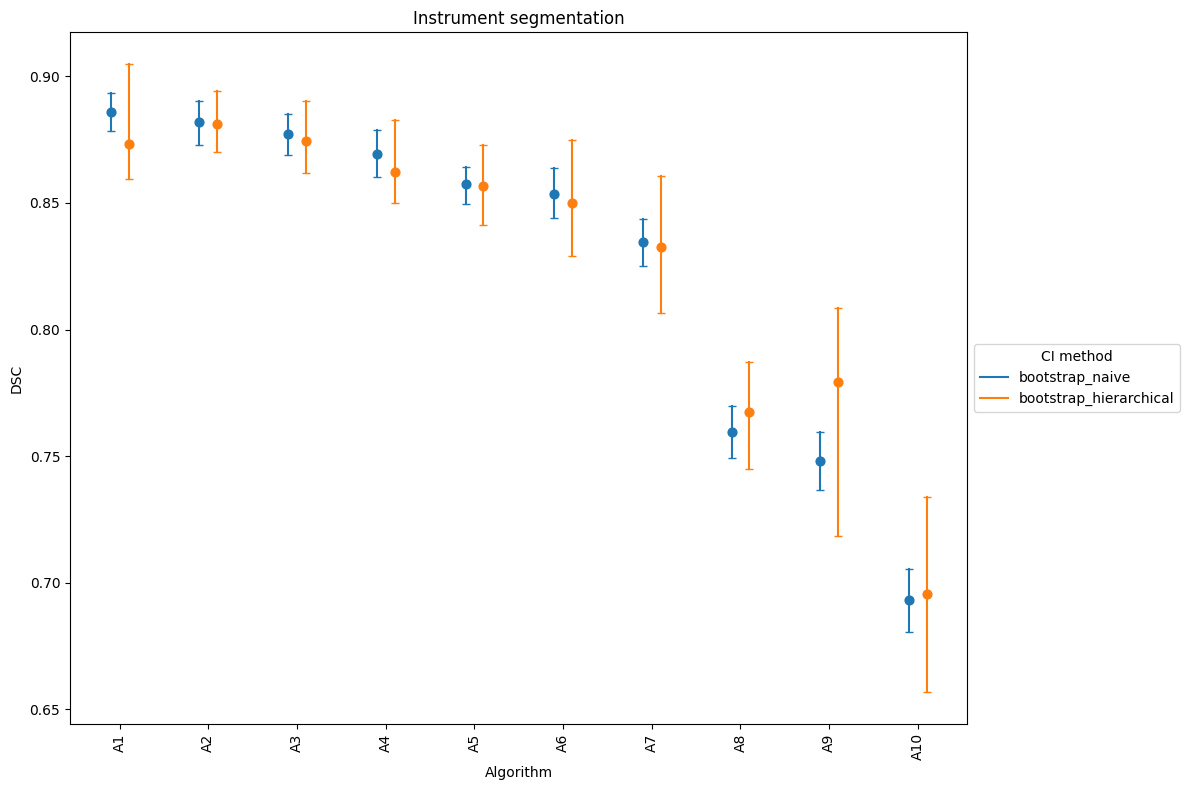

In [13]:
# -----------------------------
# Visualize confidence intervals
# -----------------------------
plt.figure(figsize=(12, 8))

# Color mapping for bootstrap methods
colors = {
    'bootstrap_naive': 'tab:blue',
    'bootstrap_hierarchical': 'tab:orange',
}

type_offset = {
    "bootstrap_naive": -0.1,
    "bootstrap_hierarchical": +0.1,
}

legend_labels = []

# Ensure consistent team ordering (A1–A10)
team_order = [f"A{i}" for i in range(1, 11)]
robustmis_results_df["team/fold"] = pd.Categorical(robustmis_results_df["team/fold"], categories=team_order, ordered=True)
robustmis_results_df = robustmis_results_df.sort_values("team/fold")

# Plot confidence intervals per team and bootstrap method
for i, team in enumerate(robustmis_results_df['team/fold'].unique()):
    team_results = robustmis_results_df[robustmis_results_df['team/fold'] == team]
    for j, row in enumerate(team_results.itertuples()):
        x_position = i + type_offset[row.type]

        plt.plot([x_position, x_position], [row.CI_lower, row.CI_upper],
                 marker="_", color=colors[row.type], linewidth=1.5)
        
        plt.scatter(x_position, row.value, color=colors[row.type], s=40, zorder=3)

        if row.type not in legend_labels:
            plt.plot([], [], color=colors[row.type], label=row.type)
            legend_labels.append(row.type)
plt.xticks(range(len(robustmis_results_df['team/fold'].unique())), robustmis_results_df['team/fold'].unique(), rotation=90)
plt.xlabel('Algorithm')
plt.ylabel('DSC')
plt.title("Instrument segmentation")
plt.legend(title='CI method', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.show()

In [14]:
# Calculate CI width
robustmis_results_df["CI_width"] = robustmis_results_df["CI_upper"] - robustmis_results_df["CI_lower"]

# Reshape so that naive and hierarchical widths are separate columns
robustmis_pivot_df = robustmis_results_df.pivot(index="team/fold", columns="type", values="CI_width")

# Ratio of hierarchical to naive CI widths
robustmis_pivot_df["CI_ratio"] = robustmis_pivot_df["bootstrap_hierarchical"] / robustmis_pivot_df["bootstrap_naive"]

print(robustmis_pivot_df)

# Summary statistic: median CI width ratio across algorithms
median_ratio_robustmis = np.median(robustmis_pivot_df["CI_ratio"])

print("\nMedian CI width ratio (hierarchical / naive):")
print(median_ratio_robustmis)

type       bootstrap_hierarchical  bootstrap_naive  CI_ratio
team/fold                                                   
A1                       0.045398         0.015299  2.967384
A2                       0.024326         0.017270  1.408613
A3                       0.028156         0.015966  1.763488
A4                       0.032843         0.018737  1.752844
A5                       0.031541         0.014435  2.185080
A6                       0.045520         0.019616  2.320519
A7                       0.054089         0.018465  2.929341
A8                       0.042326         0.020615  2.053179
A9                       0.090022         0.022837  3.941924
A10                      0.076916         0.024632  3.122625

Median CI width ratio (hierarchical / naive):
2.252799542859121


In [15]:
# Save CI width results locally
output_filename = f"robustmis_dsc_ci_width_seed_{RANDOM_SEED}.csv"
robustmis_pivot_df.to_csv(output_filename)

## Binary instrument segmentation (NSD)

Repeat for the NSD metric.

In [16]:
robustmis_results_nsd=[]

# Iterate over all algorithms
for team in robustmis_data['team_name'].unique():
    print(f"Processing team: {team}")
    
    # Subset data for the current algorithm
    team_df = robustmis_data[robustmis_data['team_name'] == team]
    
    # --- Hierarchical bootstrap ---
    bootstrap_results_hier = bootstrap_hierarchical_one_level(team_df, N_BOOTSTRAPS, 'surgery_number', 'NSD')
    hierarchical_ci_lower, hierarchical_ci_upper = np.percentile(bootstrap_results_hier, [2.5, 97.5])
    
    # --- Naive bootstrap ---
    naive_ci_lower, naive_ci_upper = bootstrap_naive(team_df, N_BOOTSTRAPS, 'NSD')
    
    # Point estimates
    naive_mean = np.mean(team_df['NSD'])
    hierar_mean = hierarchical_mean(team_df, 'surgery_number', 'NSD')

    # Store results
    robustmis_results_nsd.append({'team/fold': team, 'type': 'bootstrap_naive', 
                    'CI_lower': naive_ci_lower, 'CI_upper':naive_ci_upper, 'metric':'NSD', 'value':naive_mean})
    robustmis_results_nsd.append({'team/fold': team, 'type': 'bootstrap_hierarchical', 
                    'CI_lower':hierarchical_ci_lower, 'CI_upper': hierarchical_ci_upper,'metric':'NSD', 'value':hierar_mean})
    
# Convert to DataFrame
robustmis_results_nsd_df = pd.DataFrame(robustmis_results_nsd)
robustmis_results_nsd_df

Processing team: A1
Processing team: A9
Processing team: A8
Processing team: A2
Processing team: A10
Processing team: A7
Processing team: A3
Processing team: A6
Processing team: A4
Processing team: A5


,team/fold,type,CI_lower,CI_upper,metric,value
0,A1,bootstrap_naive,0.935238,0.949240,NSD,0.942324
1,A1,bootstrap_hierarchical,0.918993,0.959927,NSD,0.930271
2,A9,bootstrap_naive,0.000000,0.000000,NSD,0.000000
3,A9,bootstrap_hierarchical,0.000000,0.000000,NSD,0.000000
4,A8,bootstrap_naive,0.832127,0.853486,NSD,0.842948
5,A8,bootstrap_hierarchical,0.829329,0.867852,NSD,0.850786
6,A2,bootstrap_naive,0.923172,0.940602,NSD,0.931813
7,A2,bootstrap_hierarchical,0.920660,0.944508,NSD,0.931512
8,A10,bootstrap_naive,0.768210,0.792879,NSD,0.780597
9,A10,bootstrap_hierarchical,0.743492,0.820695,NSD,0.782727


In [17]:
# Calculate CI width
robustmis_results_nsd_df["CI_width"] = robustmis_results_nsd_df["CI_upper"] - robustmis_results_nsd_df["CI_lower"]

# Reshape so that naive and hierarchical widths are separate columns
robustmis_pivot_nsd_df = robustmis_results_nsd_df.pivot(index="team/fold", columns="type", values="CI_width")

# Ratio of hierarchical to naive CI widths
robustmis_pivot_nsd_df["CI_ratio"] = robustmis_pivot_nsd_df["bootstrap_hierarchical"] / robustmis_pivot_nsd_df["bootstrap_naive"]

print(robustmis_pivot_nsd_df)

# Summary statistic: median CI width ratio across algorithms
median_ratio_robustmis_nsd = np.nanmedian(robustmis_pivot_nsd_df["CI_ratio"])

print("\nMedian CI width ratio (hierarchical / naive):")
print(median_ratio_robustmis_nsd)

# Save CI width results locally
output_filename = f"robustmis_nsd_ci_width_seed_{RANDOM_SEED}.csv"
robustmis_pivot_nsd_df.to_csv(output_filename)

type       bootstrap_hierarchical  bootstrap_naive  CI_ratio
team/fold                                                   
A1                       0.040935         0.014003  2.923378
A10                      0.077203         0.024669  3.129529
A2                       0.023849         0.017430  1.368262
A3                       0.027730         0.015252  1.818098
A4                       0.033033         0.018621  1.774012
A5                       0.031968         0.015391  2.077143
A6                       0.045724         0.020379  2.243702
A7                       0.055569         0.019227  2.890121
A8                       0.038523         0.021359  1.803558
A9                       0.000000         0.000000       NaN

Median CI width ratio (hierarchical / naive):
2.077143319950698


## Action Triplet Recognition

We next apply the same bootstrap strategies to the surgical action triplet recognition task using the CholecT45 dataset.

For this task:
- The higher-level unit is the **video/patient**, identified by `video`.
- Bootstrap resampling is performed **within each cross-validation fold**.
- Metrics (mAP, weighted mAP, top-5 Accuracy) are computed at the frame level and aggregated hierarchically.

**Note on class imbalance and bootstrap resampling.**  
Due to the strong class imbalance in the CholecT45 dataset, some bootstrap resamples may not contain positive instances for all triplet classes. In such cases, metric computation follows the default behavior of `torchmetrics`, which issues a warning and applies a convention for undefined recall. This does not affect the comparative conclusions of this experiment.

In [19]:
def process_fold(fold_id, metric_fn, n_iterations):
    """
    Computes naive and hierarchical bootstrap confidence intervals for a single cross-validation fold.

    Parameters
    ----------
    fold_id : int
        Cross-validation fold index.
    metric_fn : callable
        Metric function to evaluate (e.g., mAP, weighted mAP, top-K accuracy).
    n_iterations : int
        Number of bootstrap iterations.

    Returns
    -------
    results : list of dict
        Two result dictionaries (naive and hierarchical bootstrap).
    """

    print(f"Processing fold {fold_id} with metric {metric_fn.__name__}")
    
    # Subset data for the current fold
    fold_df = atr_data[atr_data.fold == fold_id].copy().reset_index()
    
    # --- Hierarchical bootstrap ---
    bootstrap_results_hier = bootstrap_hierarchical_one_level(fold_df, n_iterations, 'video', metric_fn)
    hierarchical_ci_lower, hierarchical_ci_upper = np.percentile(bootstrap_results_hier, [2.5, 97.5])
    
    # --- Naive bootstrap ---
    naive_ci_lower, naive_ci_upper = bootstrap_naive(fold_df, n_iterations, metric_fn)
    
    # Point estimates
    naive_mean = metric_fn(fold_df)
    
    # Convert torch scalar to Python float if necessary
    if hasattr(naive_mean, "item"):
        naive_mean = naive_mean.item()
    
    hierar_mean = hierarchical_mean(fold_df, 'video', metric_fn)
   
    return [
        {
            'team/fold': fold_id, 'type': 'bootstrap_hierarchical', 
            'CI_lower': hierarchical_ci_lower, "CI_upper": hierarchical_ci_upper,
            'metric':metric_fn.__name__, 'value':hierar_mean 
        },
        {
            'team/fold': fold_id, 'type': 'bootstrap_naive', 
            'CI_lower': naive_ci_lower,"CI_upper": naive_ci_upper, 
            'metric': metric_fn.__name__,'value':naive_mean
        }
    ]

In [20]:
folds = range(5)
atr_metrics = [compute_top_k_accuracy, compute_weightedmAP_naive, compute_mAP_naive]  

inputs = [
    (fold, metric, N_BOOTSTRAPS)
    for fold, metric in itertools.product(folds, atr_metrics)
]

atr_results = []
with concurrent.futures.ThreadPoolExecutor() as executor:
    for res1, res2 in executor.map(lambda args: process_fold(*args), inputs):
        atr_results.append(res1)
        atr_results.append(res2)

atr_results_df = pd.DataFrame(atr_results)

Processing fold 0 with metric compute_top_k_accuracy
Processing fold 0 with metric compute_weightedmAP_naive
Processing fold 0 with metric compute_mAP_naive
Processing fold 1 with metric compute_top_k_accuracy
Processing fold 1 with metric compute_weightedmAP_naive
Processing fold 1 with metric compute_mAP_naive
Processing fold 2 with metric compute_top_k_accuracy
Processing fold 2 with metric compute_weightedmAP_naive
Processing fold 2 with metric compute_mAP_naive
Processing fold 3 with metric compute_top_k_accuracy
Processing fold 3 with metric compute_weightedmAP_naive
Processing fold 3 with metric compute_mAP_naive


C:\Users\reinkea\Documents\Arbeit\Paper\Data licenses and sharing\Final analysis\venv\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)


Processing fold 4 with metric compute_top_k_accuracy


C:\Users\reinkea\Documents\Arbeit\Paper\Data licenses and sharing\Final analysis\venv\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)


Processing fold 4 with metric compute_weightedmAP_naive


C:\Users\reinkea\Documents\Arbeit\Paper\Data licenses and sharing\Final analysis\venv\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)


Processing fold 4 with metric compute_mAP_naive


C:\Users\reinkea\Documents\Arbeit\Paper\Data licenses and sharing\Final analysis\venv\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)


In [21]:
atr_results_df

,team/fold,type,CI_lower,CI_upper,metric,value
0,0,bootstrap_hierarchical,0.847333,0.902160,compute_top_k_accuracy,0.876017
1,0,bootstrap_naive,0.869005,0.878074,compute_top_k_accuracy,0.873715
2,0,bootstrap_hierarchical,0.714826,0.780192,compute_weightedmAP_naive,0.743241
3,0,bootstrap_naive,0.695350,0.706478,compute_weightedmAP_naive,0.700069
4,0,bootstrap_hierarchical,0.685367,0.758761,compute_mAP_naive,0.721171
5,0,bootstrap_naive,0.718995,0.728806,compute_mAP_naive,0.723991
6,1,bootstrap_hierarchical,0.818325,0.894518,compute_top_k_accuracy,0.860110
7,1,bootstrap_naive,0.848456,0.859636,compute_top_k_accuracy,0.854047
8,1,bootstrap_hierarchical,0.729314,0.790643,compute_weightedmAP_naive,0.754374
9,1,bootstrap_naive,0.693249,0.703886,compute_weightedmAP_naive,0.697908


## Uncertainty comparison for action triplet recognition

We visualize and quantify the effect of accounting for hierarchical data dependencies on uncertainty estimation for the action triplet recognition task.

For each metric, we:
For each evaluation metric, we:
- compute confidence interval widths per fold for both naive and hierarchical bootstrap resampling,
- summarize uncertainty across folds using the median confidence interval width for each bootstrap method, and
- quantify uncertainty inflation by computing the ratio of hierarchical to naive median confidence interval widths.

In [22]:
# Calculate CI width 
atr_summary_tables = {}

for metric_name in atr_results_df["metric"].unique():
    atr_df_metric = atr_results_df[atr_results_df["metric"] == metric_name].copy()

    # CI width per fold and bootstrap method
    atr_df_metric["CI_width"] = atr_df_metric["CI_upper"] - atr_df_metric["CI_lower"]

    # Median over folds 
    df_median_folds_atr = (
        atr_df_metric
        .groupby("type")
        .agg(
            CI_lower_median=("CI_lower", "median"),
            CI_upper_median=("CI_upper", "median"),
            CI_width_median=("CI_width", "median"),
            mean_median=("value", "median"),
        )
        .reset_index()
    )

    # Compute ratio 
    ci_width_naive = df_median_folds_atr.loc[
        df_median_folds_atr["type"] == "bootstrap_naive",
        "CI_width_median"
    ].values[0]

    ci_width_hier = df_median_folds_atr.loc[
        df_median_folds_atr["type"] == "bootstrap_hierarchical",
        "CI_width_median"
    ].values[0]

    ratio_from_medians = ci_width_hier / ci_width_naive

    # Attach same ratio to both rows 
    df_median_folds_atr["ratio"] = ratio_from_medians

    atr_summary_tables[metric_name] = df_median_folds_atr
    
# Combine across metrics
atr_summary_all = []

for metric_name, df in atr_summary_tables.items():
    df_out = df.copy()
    df_out["metric"] = metric_name  # keep metric identifier
    atr_summary_all.append(df_out)

atr_summary_all_df = pd.concat(atr_summary_all, ignore_index=True)

atr_summary_all_df

,type,CI_lower_median,CI_upper_median,CI_width_median,mean_median,ratio,metric
0,bootstrap_hierarchical,0.818325,0.894518,0.076501,0.860110,7.179264,compute_top_k_accuracy
1,bootstrap_naive,0.848456,0.859636,0.010656,0.854047,7.179264,compute_top_k_accuracy
2,bootstrap_hierarchical,0.687366,0.790643,0.126727,0.743241,10.850083,compute_weightedmAP_naive
3,bootstrap_naive,0.686869,0.698548,0.011680,0.691723,10.850083,compute_weightedmAP_naive
4,bootstrap_hierarchical,0.633584,0.758761,0.162045,0.707731,13.343403,compute_mAP_naive
5,bootstrap_naive,0.696503,0.708647,0.012144,0.702438,13.343403,compute_mAP_naive


In [23]:
# Save CI width results locally
output_filename = f"atr_ci_width_seed_{RANDOM_SEED}.csv"
atr_summary_all_df.to_csv(output_filename)

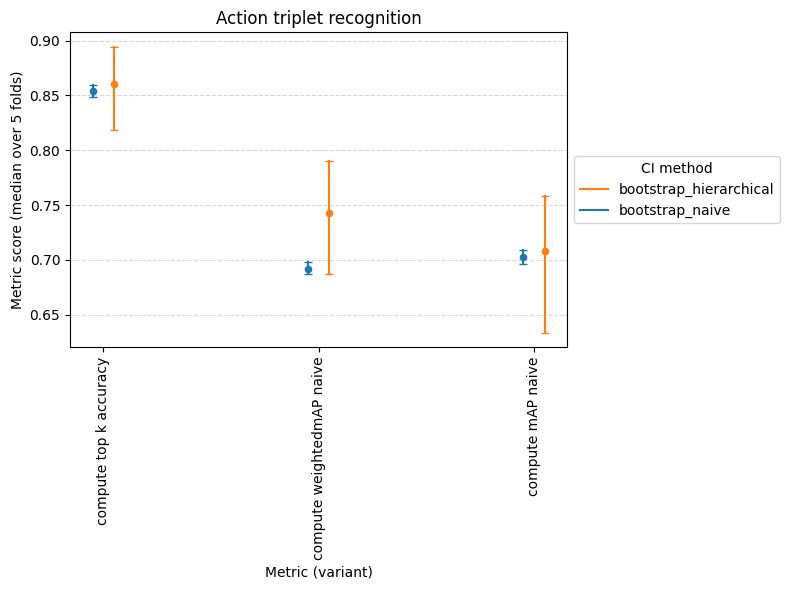

In [24]:
# -----------------------------
# Visualize confidence intervals
# -----------------------------
plt.figure(figsize=(8, 6))

colors = {
    'bootstrap_naive': 'tab:blue',
    'bootstrap_hierarchical': 'tab:orange',
}

type_offset = {
    "bootstrap_naive": -0.05,
    "bootstrap_hierarchical": +0.05,
}

legend_labels = []

# Ensure consistent metric ordering
metric_order = atr_summary_all_df["metric"].unique()
atr_summary_all_df["metric"] = pd.Categorical(atr_summary_all_df["metric"], categories=metric_order, ordered=True)
atr_summary_all_df = atr_summary_all_df.sort_values("metric")

# Plot confidence intervals per metric and bootstrap method
for i, metric_name in enumerate(metric_order):

    metric_df = atr_summary_all_df[
        atr_summary_all_df["metric"] == metric_name
    ]

    for j, row in enumerate(metric_df.itertuples()):
        x_position = i + type_offset[row.type]

        plt.plot([x_position, x_position], [row.CI_lower_median, row.CI_upper_median], 
                 marker="_", color=colors[row.type], linewidth=1.5)
        
        plt.scatter(x_position, row.mean_median, color=colors[row.type], s=20, zorder=3)

        if row.type not in legend_labels:
            plt.plot([], [], color=colors[row.type], label=row.type)
            legend_labels.append(row.type)

plt.xticks(range(len(metric_order)), [m.replace("_", " ") for m in metric_order], rotation=90)
plt.xlabel("Metric (variant)")
plt.ylabel("Metric score (median over 5 folds)")
plt.title("Action triplet recognition")
plt.legend(title="CI method", loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()